<a href="https://colab.research.google.com/github/mandavi-singh/age-group-classification-ml-hackathon/blob/main/NHANES_age_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
train = pd.read_csv('/content/Train_Data (1).csv')
test = pd.read_csv('/content/Test_Data (1).csv')
sample_submission = pd.read_csv('/content/Sample_Submission (1).csv')

print(train.shape, test.shape)
train.head()


(1966, 9) (312, 8)


,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [ ]:
print(test.head())

      SEQN  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN
0  77017.0       1.0     1.0    32.2    96.0     2.0   135.0  15.11
1  75580.0       2.0     2.0    26.3   100.0     2.0   141.0  15.26
2  73820.0       1.0     2.0    28.6   107.0     2.0   136.0   8.82
3  80489.0       2.0     1.0    22.1    93.0     2.0   111.0  12.13
4  82047.0       1.0     1.0    24.7    91.0     2.0   105.0   3.12


In [ ]:
print(train.columns)

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN', 'age_group'],
      dtype='object')


In [ ]:
print(test.columns)

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN'],
      dtype='object')


In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1952 entries, 0 to 1965
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1940 non-null   float64
 1   RIAGENDR   1934 non-null   float64
 2   PAQ605     1939 non-null   float64
 3   BMXBMI     1934 non-null   float64
 4   LBXGLU     1939 non-null   float64
 5   DIQ010     1934 non-null   float64
 6   LBXGLT     1941 non-null   float64
 7   LBXIN      1943 non-null   float64
 8   age_group  1952 non-null   float64
dtypes: float64(9)
memory usage: 152.5 KB
None


In [ ]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      310 non-null    float64
 1   RIAGENDR  310 non-null    float64
 2   PAQ605    311 non-null    float64
 3   BMXBMI    311 non-null    float64
 4   LBXGLU    311 non-null    float64
 5   DIQ010    311 non-null    float64
 6   LBXGLT    310 non-null    float64
 7   LBXIN     311 non-null    float64
dtypes: float64(8)
memory usage: 19.6 KB
None


In [ ]:
target_info = pd.DataFrame({
    'Label': [0, 1],
    'Meaning': ['Adult (less than 65)', 'Senior (65 and above)']
})
print(target_info)

   Label                Meaning
0      0   Adult (less than 65)
1      1  Senior (65 and above)


In [ ]:
print(train.describe())

               SEQN     RIAGENDR       PAQ605       BMXBMI       LBXGLU  \
count   1940.000000  1934.000000  1939.000000  1934.000000  1939.000000   
mean   78685.510825     1.509307     1.825683    27.981127    99.466220   
std     2927.348984     0.500043     0.399355     7.343856    16.738574   
min    73564.000000     1.000000     1.000000    14.500000    63.000000   
25%    76188.250000     1.000000     2.000000    22.800000    91.000000   
50%    78719.000000     2.000000     2.000000    26.800000    97.000000   
75%    81222.750000     2.000000     2.000000    31.300000   104.000000   
max    83727.000000     2.000000     7.000000    70.100000   405.000000   

            DIQ010       LBXGLT        LBXIN    age_group  
count  1934.000000  1941.000000  1943.000000  1952.000000  
mean      2.015512   115.070067    11.875265     0.160861  
std       0.186916    46.133851     9.779149     0.367497  
min       1.000000    40.000000     0.140000     0.000000  
25%       2.000000    87

In [ ]:
print(test.describe())

               SEQN    RIAGENDR      PAQ605      BMXBMI      LBXGLU  \
count    310.000000  310.000000  311.000000  311.000000  311.000000   
mean   78717.490323    1.522581    1.803859   27.810611  100.067524   
std     2905.999069    0.500297    0.397717    6.717031   23.920539   
min    73659.000000    1.000000    1.000000   15.900000   69.000000   
25%    76006.500000    1.000000    2.000000   22.950000   92.000000   
50%    79036.500000    2.000000    2.000000   26.800000   97.000000   
75%    81167.000000    2.000000    2.000000   30.900000  103.000000   
max    83694.000000    2.000000    2.000000   54.900000  368.000000   

           DIQ010      LBXGLT       LBXIN  
count  311.000000  310.000000  311.000000  
mean     2.019293  114.241935   11.666463  
std      0.159477   52.356101    9.570438  
min      1.000000   43.000000    1.040000  
25%      2.000000   86.000000    6.120000  
50%      2.000000  102.500000    9.220000  
75%      2.000000  128.750000   14.185000  
max     

age_group
0.0    1638
1.0     314
Name: count, dtype: int64


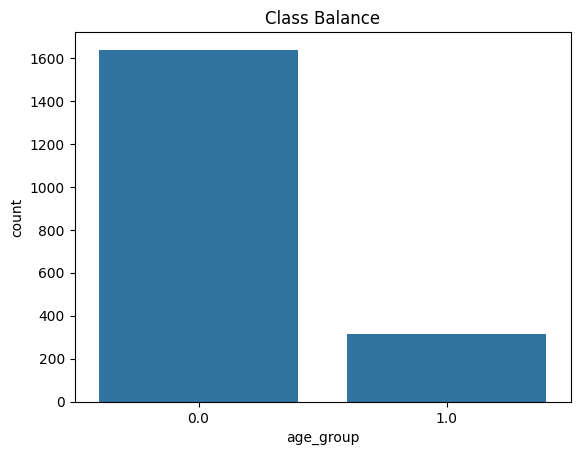

SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64
SEQN        2
RIAGENDR    2
PAQ605      1
BMXBMI      1
LBXGLU      1
DIQ010      1
LBXGLT      2
LBXIN       1
dtype: int64


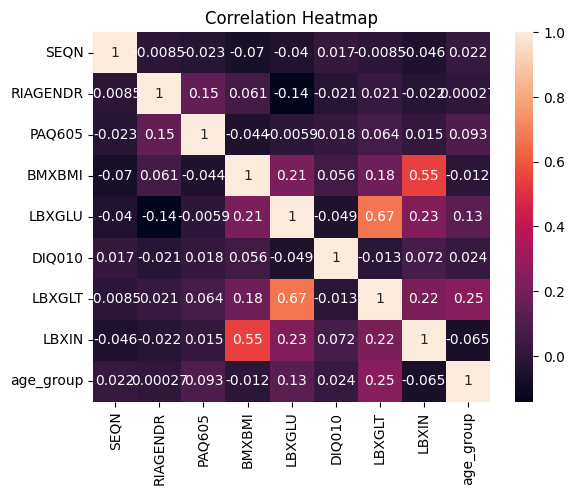

In [ ]:

train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1})

# EDA
print(train['age_group'].value_counts())
sns.countplot(data=train, x='age_group')
plt.title('Class Balance')
plt.show()

print(train.isnull().sum())
print(test.isnull().sum())

sns.heatmap(train.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()



In [ ]:
# Drop rows with missing target
train = train.dropna(subset=['age_group'])

X = train.drop(['SEQN', 'age_group'], axis=1)
y = train['age_group']


In [ ]:
print(X.isnull().sum())
print(y.isnull().sum())


RIAGENDR    18
PAQ605      13
BMXBMI      18
LBXGLU      13
DIQ010      18
LBXGLT      11
LBXIN        9
dtype: int64
0


In [ ]:
print(y.isnull().sum())  # Should show 0


0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
X = train.drop(['SEQN', 'age_group'], axis=1)
y = train['age_group']
X_test = test.drop(['SEQN'], axis=1)


In [ ]:
X = X.fillna(X.mean())
X_test = X_test.fillna(X.mean())

In [ ]:
for df in [X_train, X_val, X_test]:
    df['BMI_Glucose'] = df['BMXBMI'] * df['LBXGLU']
    df['Glucose_Insulin'] = df['LBXGLU'] * df['LBXIN']
    df['BMI_Insulin'] = df['BMXBMI'] * df['LBXIN']


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


In [ ]:
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42, class_weight='balanced')
lr_l2.fit(X_train_scaled, y_train)
val_preds_l2 = lr_l2.predict(X_val_scaled)
print("L2 F1:", f1_score(y_val, val_preds_l2))


L2 F1: 0.38974358974358975


In [ ]:
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm.fit(X_train_scaled, y_train)
val_preds_svm = svm.predict(X_val_scaled)
print("SVM F1:", f1_score(y_val, val_preds_svm))


SVM F1: 0.3854166666666667


In [ ]:
svm = SVC(probability=True, class_weight='balanced', random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(svm, param_grid_svm, scoring='f1', cv=3, verbose=1)
grid_svm.fit(X_train_scaled, y_train)
print("SVM Best F1:", grid_svm.best_score_)
print("SVM Best Params:", grid_svm.best_params_)
val_preds_svm = grid_svm.predict(X_val_scaled)
print("SVM Validation F1:", f1_score(y_val, val_preds_svm))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Best F1: 0.4414835249931644
SVM Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Validation F1: 0.37158469945355194


In [ ]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
val_preds_rf = rf.predict(X_val)
print("Random Forest F1:", f1_score(y_val, val_preds_rf))


Random Forest F1: 0.2


In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
val_preds_xgb = xgb.predict(X_val)
print("XGBoost F1:", f1_score(y_val, val_preds_xgb))


scale_pos_weight: 5.22
XGBoost F1: 0.3431952662721893


In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("Scale pos weight:", scale_pos_weight)

xgb = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 0.9]
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='f1', cv=3, verbose=1)
grid_xgb.fit(X_train_scaled, y_train)
print("XGB Best F1:", grid_xgb.best_score_)
print("XGB Best Params:", grid_xgb.best_params_)
val_preds_xgb = grid_xgb.predict(X_val_scaled)
print("XGB Validation F1:", f1_score(y_val, val_preds_xgb))


Scale pos weight: 5.219123505976095
Fitting 3 folds for each of 32 candidates, totalling 96 fits
XGB Best F1: 0.42439517318699477
XGB Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
XGB Validation F1: 0.3333333333333333


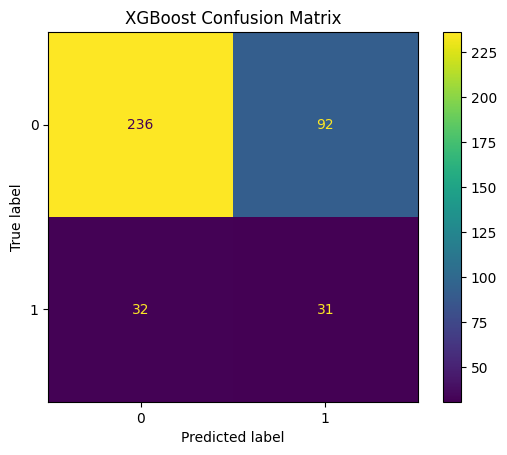

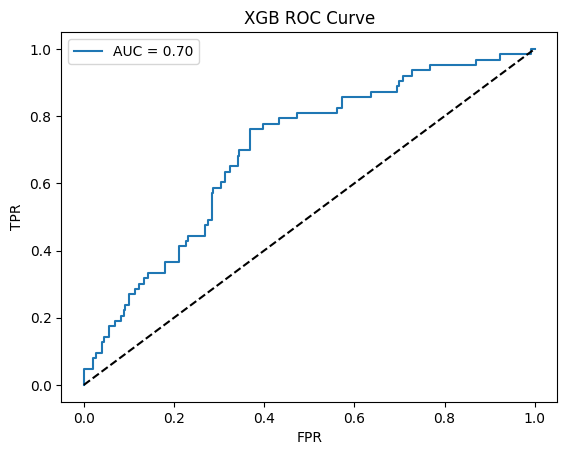

In [ ]:
# Confusion Matrix for XGB
ConfusionMatrixDisplay(confusion_matrix(y_val, val_preds_xgb)).plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

# ROC
y_proba_xgb = grid_xgb.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_proba_xgb)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('XGB ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

xgb_gs = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

grid = GridSearchCV(xgb_gs, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best GridSearch F1:", grid.best_score_)
print("Best Params:", grid.best_params_)

best_xgb = grid.best_estimator_
val_preds_best = best_xgb.predict(X_val)
print("Validation F1:", f1_score(y_val, val_preds_best))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best GridSearch F1: 0.43640066824090307
Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Validation F1: 0.36065573770491804


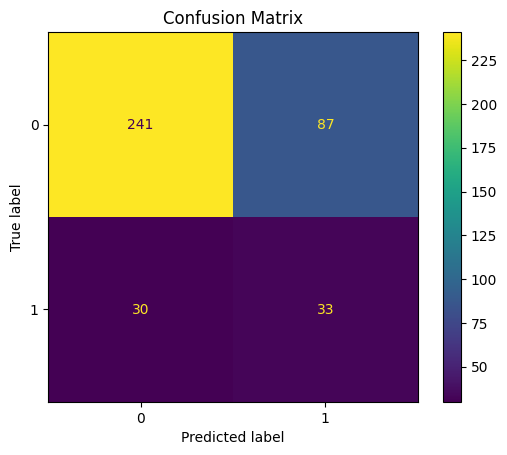

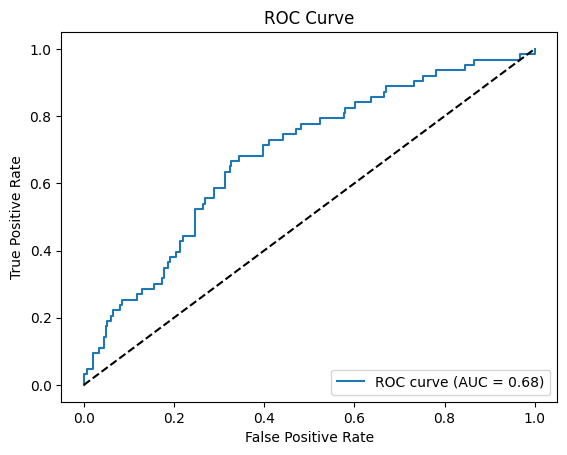

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, val_preds_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_proba = best_xgb.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from lightgbm import LGBMClassifier


scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

lgbm.fit(X_train, y_train)

val_preds_lgbm = lgbm.predict(X_val)
print("LightGBM F1:", f1_score(y_val, val_preds_lgbm))


Scale pos weight: 5.22
[LightGBM] [Info] Number of positive: 251, number of negative: 1310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 1561, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160794 -> initscore=-1.652329
[LightGBM] [Info] Start training from score -1.652329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

lgbm_gs = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

grid = GridSearchCV(lgbm_gs, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best LGBM F1:", grid.best_score_)
print("Best Params:", grid.best_params_)

best_lgbm = grid.best_estimator_
val_preds_best_lgbm = best_lgbm.predict(X_val)
print("Validation F1:", f1_score(y_val, val_preds_best_lgbm))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 251, number of negative: 1310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1515
[LightGBM] [Info] Number of data points in the train set: 1561, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160794 -> initscore=-1.652329
[LightGBM] [Info] Start training from score -1.652329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

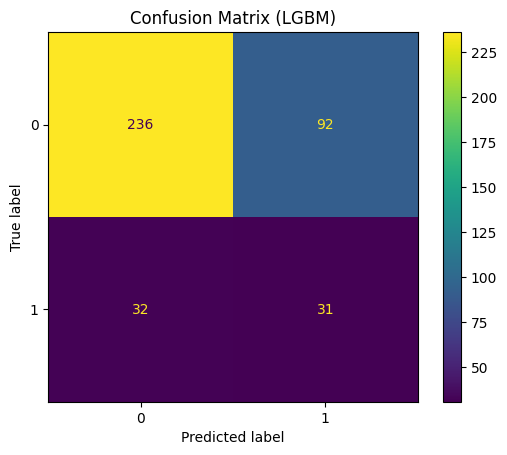

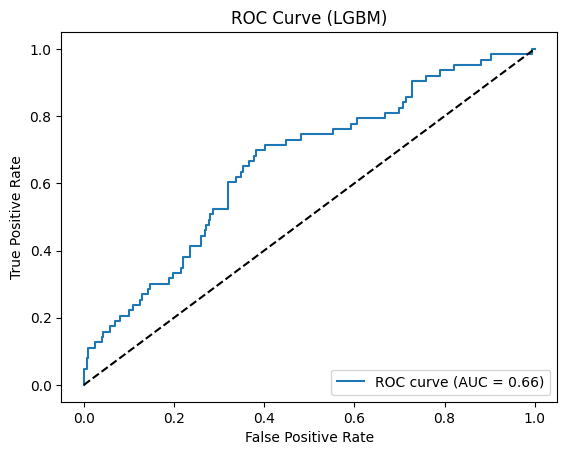

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, val_preds_best_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title("Confusion Matrix (LGBM)")
plt.show()

# ROC Curve
y_proba = best_lgbm.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LGBM)')
plt.legend(loc="lower right")
plt.show()


KNN F1: 0.2268041237113402


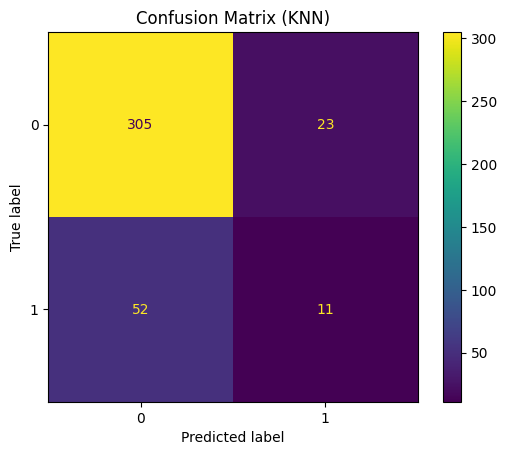

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled, y_train)
val_preds_knn = knn.predict(X_val_scaled)

print("KNN F1:", f1_score(y_val, val_preds_knn))

# Confusion Matrix
cm_knn = confusion_matrix(y_val, val_preds_knn)
ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=[0,1]).plot()
plt.title("Confusion Matrix (KNN)")
plt.show()


GaussianNB F1: 0.25263157894736843


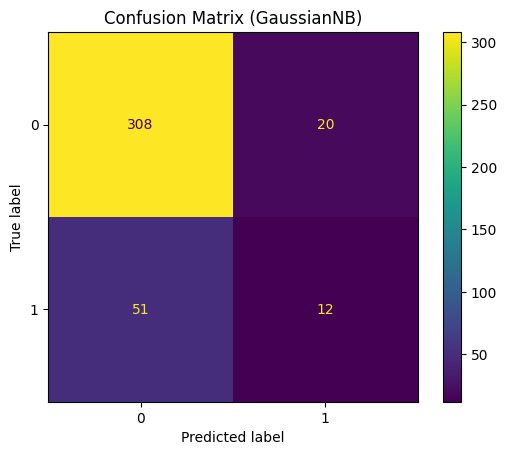

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
val_preds_gnb = gnb.predict(X_val)

print("GaussianNB F1:", f1_score(y_val, val_preds_gnb))

# Confusion Matrix
cm_gnb = confusion_matrix(y_val, val_preds_gnb)
ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=[0,1]).plot()
plt.title("Confusion Matrix (GaussianNB)")
plt.show()


Decision Tree F1: 0.32673267326732675


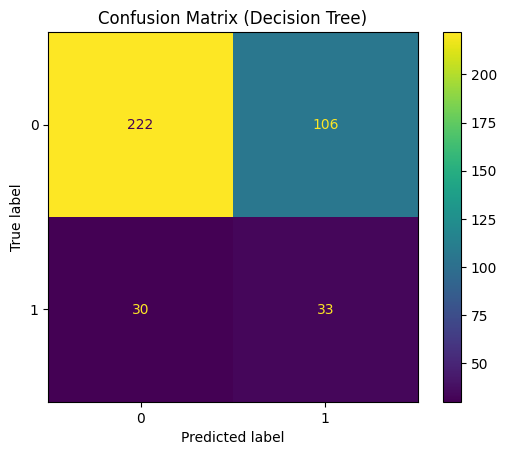

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtree = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

dtree.fit(X_train, y_train)
val_preds_dtree = dtree.predict(X_val)

print("Decision Tree F1:", f1_score(y_val, val_preds_dtree))

# Confusion Matrix
cm_dtree = confusion_matrix(y_val, val_preds_dtree)
ConfusionMatrixDisplay(confusion_matrix=cm_dtree, display_labels=[0,1]).plot()
plt.title("Confusion Matrix (Decision Tree)")
plt.show()



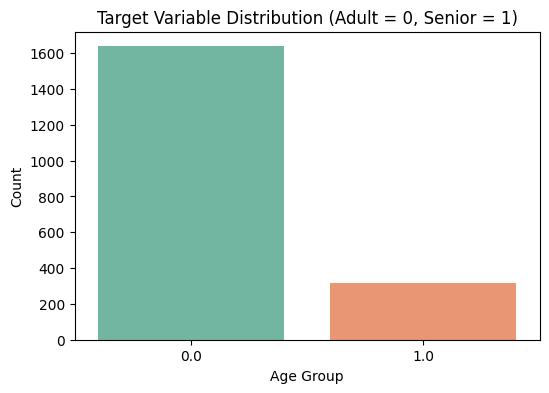

In [ ]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="Set2")
plt.title("Target Variable Distribution (Adult = 0, Senior = 1)")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

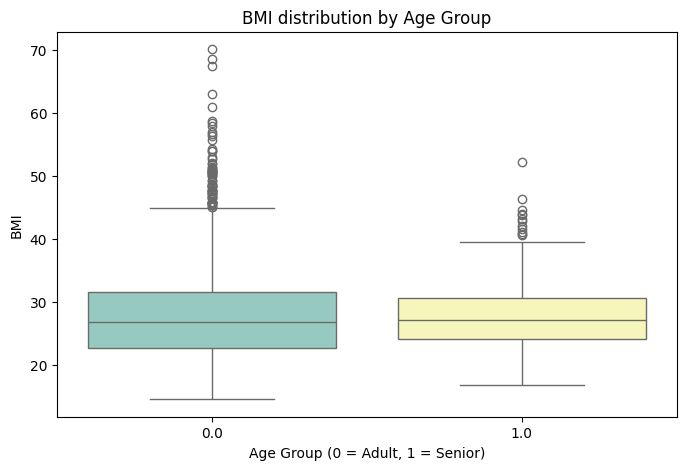

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=y, y=X['BMXBMI'], palette="Set3")
plt.title("BMI distribution by Age Group")
plt.xlabel("Age Group (0 = Adult, 1 = Senior)")
plt.ylabel("BMI")
plt.show()

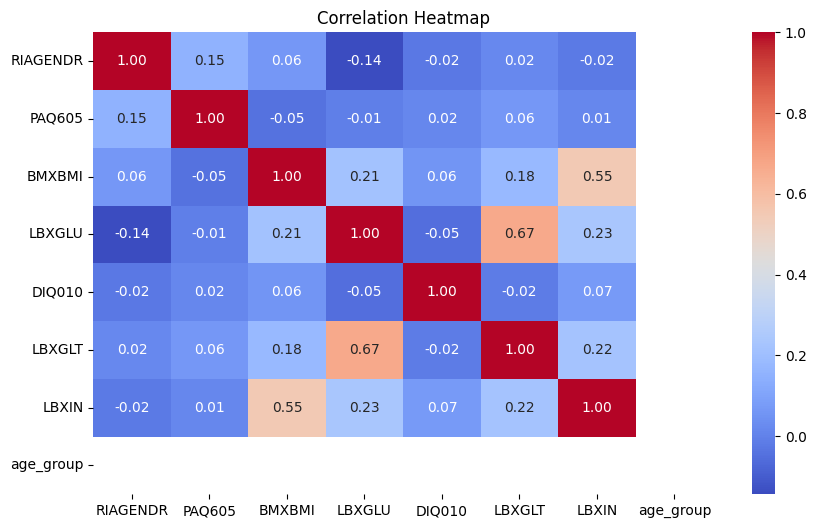

In [ ]:
train_corr = train.copy()
train_corr['age_group'] = train_corr['age_group'].map({'Adult': 0, 'Senior': 1})

plt.figure(figsize=(10, 6))
sns.heatmap(train_corr.drop(['SEQN'], axis=1).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
best_svm = SVC(
    C=0.1,
    kernel='linear',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)


best_svm.fit(X_train_scaled, y_train)


test_preds = best_svm.predict(X_test_scaled)


submission = pd.DataFrame({
    'age_group': test_preds.astype(int)
})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as: submission.csv")
print(submission['age_group'].value_counts())

Submission file saved as: submission.csv
age_group
0    222
1     90
Name: count, dtype: int64


In [ ]:
# Load both to check
sub = pd.read_csv("submission.csv")
sample = pd.read_csv("Sample_Submission (1).csv")

print("Submission shape:", sub.shape)
print("Sample shape:", sample.shape)
print("\nSubmission head:\n", sub.head())
print("\nSample head:\n", sample.head())
print("\nUnique values:", sub['age_group'].unique())


Submission shape: (312, 1)
Sample shape: (312, 1)

Submission head:
    age_group
0          0
1          1
2          1
3          0
4          0

Sample head:
    age_group
0          0
1          0
2          0
3          0
4          0

Unique values: [0 1]
